# Machine Learning
# Exercise 4 - Deep Learning
<br/>Student:
<br/>se21m024
<br/>Matriculation number: 1425616
<br/>Thomas Stummer
<br/><br/>The interpretation of the data can be found in the document <b><i>se21m024_Stummer_ml_ex4_deep.pdf</i></b>.
<br/><br/>
The source code was heavily inspired by https://github.com/tuwien-musicir/DeepLearning_Tutorial/ and the code snippets provided by https://www.cs.toronto.edu/~kriz/cifar.html.
<br/><br/>
Data Set: CIFAR-10<br>
"The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. The classes are completely mutually exclusive." [Description taken from https://www.cs.toronto.edu/~kriz/cifar.html]<br>
CIFAR-10 python version downloaded from https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz<br>
Reference: Learning Multiple Layers of Features from Tiny Images, Alex Krizhevsky, 2009.
<br/><br/>

## Import Dependencies

In [46]:
import os
import argparse
import csv
import datetime
import glob
import math
import sys
import time
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import accuracy_score
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dense, Dropout, Activation, Flatten
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
%matplotlib inline 

# Matriculation number: 1425616
random_state = 1425616
np.random.seed(random_state) # we initialize a random seed here to make the experiments repeatable with same results

# Fix batch_size and epochs for all tests to make results more comparable
batch_size = 32
epochs = 5

## Load the Images from the Data Set

In [47]:
# Unpickle files
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

path = 'cifar-10-batches-py/data_batches'
files = glob.glob(os.path.join(path, '*_*'))
print('Imported ' + str(len(files)) + ' files')

Imported 5 files


In [48]:
# Import labeled images
image_filenames = []
images = np.empty([0,3072], dtype=np.ubyte)
image_labels = []

for filename in files:
    file_data = unpickle(filename)
    image_filenames.extend(file_data[b'filenames'])
    images = np.append(images, file_data[b'data'], axis=0)
    image_labels.extend(file_data[b'labels'])
    
print('Imported ' + str(len(images)) + ' images.')

Imported 50000 images.


b'roe_deer_s_000207.png'


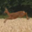

In [49]:
# Show a selected image to check
i=12645
print (image_filenames[i])
image = images[i]
Image.merge('RGB', (
    Image.fromarray(np.asarray(np.split(image[0:1024], indices_or_sections=32))),
    Image.fromarray(np.asarray(np.split(image[1024:2048], indices_or_sections=32))),
    Image.fromarray(np.asarray(np.split(image[2048:3072], indices_or_sections=32)))))

## Create the Groundtruth based on labels:

In this data set, all images are labeled.

In [50]:
# look at the first 25 classes
print('First 25 labels:\n' + str(image_labels[0:25]) + '\n')

unique_image_labels = set(image_labels)
print('Unique labels:\n' + str(unique_image_labels) + '\n')

print("Groundtruth Statistics:")
for v in unique_image_labels:
    print("Label", v, ":", image_labels.count(v))

image_classes = np_utils.to_categorical(image_labels)

First 25 labels:
[6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6, 2]

Unique labels:
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

Groundtruth Statistics:
Label 0 : 5000
Label 1 : 5000
Label 2 : 5000
Label 3 : 5000
Label 4 : 5000
Label 5 : 5000
Label 6 : 5000
Label 7 : 5000
Label 8 : 5000
Label 9 : 5000


## Standardization

Here we use <b>Zero-mean Unit-variance standardization</b> which means we deduct the mean and divide by the standard deviation.

(Note: Here, we do this "flat", i.e. one mean and std.dev. for the whole image is computed over all pixels (not per pixel); in RGB images, standardization can be done e.g. for each colour channel individually; in other/non-image data sets, attribute-wise standardization should be applied).

In [51]:
images.min(), images.max()

(0, 255)

In [52]:
mean = images.mean()
stddev = images.std()
mean, stddev

(120.70756512369792, 64.1500758911213)

In [53]:
images_std = (images - mean) / stddev
images_std = np.array(images_std, dtype=float)
images_std.mean(), images_std.std()

(-2.5247951877342226e-17, 1.0000000000000022)

In [54]:
images_std.min(), images_std.max()

(-1.8816433721538972, 2.09341038199596)

# Creating NN Models in Keras

## 1) Fully Connected NN

For a fully connected neural network, the x and y axis of an image do not play a role at all. All pixels are considered as a completely individual input to the neural network. Therefore the 2D image arrays have to be flattened to a vector. For our current data set this is already the case.

In [55]:
print(images_std.shape)

(50000, 3072)


In [56]:
# find out input shape for NN, which is just a long vector (32 x 32 x 3 = 1024 x 3 = 3072)
input_shape = images_std.shape[1]
print('Input shape for NN: ' + str(input_shape))

Input shape for NN: 3072


### Creating a Model

In Keras, one can choose between a Sequential model and a Graph model. Sequential models are the standard case. Graph models are for parallel networks and use the functional API (see Music/Speech tutorial).

Here we create a sequential model with 2 fully connected (a.k.a. 'dense') layers containing 256 units each.

The output unit is a Single sigmoid unit which can predict values between 0 and 1.

In [57]:
# simple Fully-connected network
model = Sequential()

model.add(Dense(256, input_dim=input_shape))
model.add(Dense(256, activation='sigmoid'))
model.add(Dense(len(unique_image_labels), activation='softmax'))

model.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 256)               786688    
                                                                 
 dense_15 (Dense)            (None, 256)               65792     
                                                                 
 dense_16 (Dense)            (None, 10)                2570      
                                                                 
Total params: 855,050
Trainable params: 855,050
Non-trainable params: 0
_________________________________________________________________


### Defining Loss Function and Optimizer Strategy: Gradient Descent

In [58]:
# Define a loss function 
loss = 'categorical_crossentropy'  # 'categorical_crossentropy' for multi-class problems

# Optimizer = Stochastic Gradient Descent
optimizer = 'sgd' 

# Compiling the model
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

### Training the model on the input dataset

In [59]:
# train the model
model.fit(images_std, image_classes, batch_size=batch_size, epochs=epochs)

Epoch 1/5
1563/1563 [==============================] - 5s 3ms/step - loss: 1.8184 - accuracy: 0.3654
Epoch 2/5
1563/1563 [==============================] - 4s 3ms/step - loss: 1.6938 - accuracy: 0.4130
Epoch 3/5
1563/1563 [==============================] - 4s 3ms/step - loss: 1.6408 - accuracy: 0.4344
Epoch 4/5
1563/1563 [==============================] - 4s 3ms/step - loss: 1.6028 - accuracy: 0.4499
Epoch 5/5
1563/1563 [==============================] - 4s 3ms/step - loss: 1.5699 - accuracy: 0.4637


In [60]:
# verify accuracy on train set
predictions = model.predict(images_std)
predicted_classes = np.argmax(predictions, axis=1)
image_labels_for_comparison = np.array(image_labels)
accuracy_on_training_set = accuracy_score(image_labels_for_comparison, predicted_classes)
print('Accuracy on training set: ' + str(accuracy_on_training_set))

1563/1563 [==============================] - 3s 2ms/step
Accuracy on training set: 0.47206


This is the accuracy on the training set.

# Testing with Test Data Set

In [84]:
# Unpickle files
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

path = 'cifar-10-batches-py/test_batches'
files = glob.glob(os.path.join(path, '*_*'))
print('Imported ' + str(len(files)) + ' files.')

# Import labeled images
test_image_filenames = []
test_images = np.empty([0,3072], dtype=np.ubyte)
test_image_labels = []

for filename in files:
    file_data = unpickle(filename)
    test_image_filenames.extend(file_data[b'filenames'])
    test_images = np.append(test_images, file_data[b'data'], axis=0)
    test_image_labels.extend(file_data[b'labels'])
    
test_image_labels_for_comparison = np.array(test_image_labels)
test_image_classes = np_utils.to_categorical(test_image_labels)

print('Imported ' + str(len(test_images)) + ' images.')

print("Groundtruth Statistics:")
for v in unique_image_labels:
    print("Label", v, ":", test_image_labels.count(v))

Imported 1 files.
Imported 10000 images.
Groundtruth Statistics:
Label 0 : 1000
Label 1 : 1000
Label 2 : 1000
Label 3 : 1000
Label 4 : 1000
Label 5 : 1000
Label 6 : 1000
Label 7 : 1000
Label 8 : 1000
Label 9 : 1000


### Standardize Test Set

The test data has to be standardized <b>in the same way</b> as the training data for compatibility with the model! That means, we take the mean and standard deviation of the <i>training data</i> to transform also the test data.

In [62]:
# NO! we take the same mean and stddev from the training data above!
#mean = test_images.mean()
#stddev = test_images.std()
#print mean, stddev

In [63]:
test_images.mean(), test_images.std()

(121.52915475260417, 64.06097012299574)

In [64]:
test_images_std = (test_images - mean) / stddev

In [65]:
test_images_std.mean(), test_images_std.std()

(0.012807305642173993, 0.9986109795368484)

### Make Predictions

In [66]:
# verify accuracy on test set
test_predictions = model.predict(test_images_std)
test_predicted_classes = np.argmax(test_predictions, axis=1)
accuracy_on_test_set = accuracy_score(test_image_labels_for_comparison, test_predicted_classes)
print('Accuracy on test set: ' + str(accuracy_on_test_set))

313/313 [==============================] - 1s 2ms/step
Accuracy on test set: 0.4498


# 2) Convolutional Neural Network

A Convolutional Neural Network (ConvNet or CNN) is a type of (deep) Neural Network that is well-suited for 2D axes data, such as images, as it is optimized for learning from spatial proximity. Its core elements are 2D filter kernels which essentially learn the weights of the Neural Network, and downscaling functions such as Max Pooling.

A CNN can have one or more Convolution layers, each of them having an arbitrary number of N filters (which define the depth of the CNN layer), following typically by a pooling step, which groups neighboring pixels together and thus reduces the image resolution by retaining only the maximum values of neighboring pixels.

### Input

Our input to the CNN is the standardized version of the original image array.

#### Adding the channel

For CNNs, we need to add a dimension for the color channel to the data. RGB images typically have an 3rd dimension with the color. 
<b>For greyscale images we need to add an extra dimension for compatibility with the CNN implementation.</b>

In Theano, traditionally the color channel was the <b>first</b> dimension in the image shape. 
In Tensorflow, the color channel is the <b>last</b> dimension in the image shape. 

This can be configured now in ~/.keras/keras.json: "image_dim_ordering": "th" or "tf" with "tf" (Tensorflow) being the default image ordering even though you use Theano. Depending on this, use one of the code lines below.

For greyscale images, we add the number 1 as the depth of the additional dimension of the input shape (for RGB color images, the number of channels is 3).

In [67]:
n_channels = 3 # for grey-scale, 3 for RGB, but usually already present in the data
edge_pixels = 32

keras.backend.set_image_data_format('channels_last')
train_img = images_std.reshape(images_std.shape[0], edge_pixels, edge_pixels, n_channels)
test_img = test_images_std.reshape(test_images_std.shape[0], edge_pixels, edge_pixels, n_channels)

In [68]:
print(images_std.shape)
print(test_images_std.shape)
print(train_img.shape)
print(test_img.shape)

(50000, 3072)
(10000, 3072)
(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [69]:
# we store the new shape of the images in the 'input_shape' variable.
# take all dimensions except the 0th one (which is the number of images)
    
input_shape = train_img.shape[1:]  
input_shape

(32, 32, 3)

## Create the CNN model

You may try to change the following to see the impact on the result:
* number of filters
* filter kernel size (e.g. 3 x 3, 5 x 5, ...)
* adding/not adding Batch Normalization
* adding/not adding ReLU Activation
* adding/not adding Max Pooling
* changing Pooling size (e.g. 1 x 2, 2 x 2, 2 x 1, or more)
* adding/changing/removing Dropout

In [70]:
def createMyModel():
    
    model = Sequential()

    model.add(Convolution2D(64, (3,3), input_shape=input_shape, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Convolution2D(64, (3,3), activation='relu'))
    model.add(Dropout(0.2))

    model.add(Convolution2D(64, (3,3), activation='relu'))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dense(len(unique_image_labels), activation='softmax'))
    
    return model

In [71]:
model = createMyModel()
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 30, 30, 64)        1792      
                                                                 
 dropout_12 (Dropout)        (None, 30, 30, 64)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 dropout_13 (Dropout)        (None, 28, 28, 64)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 26, 26, 64)        36928     
                                                                 
 dropout_14 (Dropout)        (None, 26, 26, 64)        0         
                                                                 
 flatten_4 (Flatten)         (None, 43264)           

## Training the CNN

In [72]:
# Compiling the model
loss = 'categorical_crossentropy' 
optimizer = 'sgd' 
#optimizer = SGD(lr=0.001)  # possibility to adapt the learn rate

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [73]:
# TRAINING the model
history = model.fit(train_img, image_classes, batch_size=batch_size, epochs=epochs)

Epoch 1/5
1563/1563 [==============================] - 171s 109ms/step - loss: 1.6308 - accuracy: 0.4215
Epoch 2/5
1563/1563 [==============================] - 177s 114ms/step - loss: 1.3339 - accuracy: 0.5308
Epoch 3/5
1563/1563 [==============================] - 181s 116ms/step - loss: 1.1947 - accuracy: 0.5802
Epoch 4/5
1563/1563 [==============================] - 180s 115ms/step - loss: 1.0805 - accuracy: 0.6232
Epoch 5/5
1563/1563 [==============================] - 179s 114ms/step - loss: 0.9829 - accuracy: 0.6585


### Verifying Accuracy on Test Set

In [75]:
# verify accuracy on test set
predictions = model.predict(test_img)
predicted_classes = np.argmax(predictions, axis=1)
accuracy_on_test_set = accuracy_score(test_image_labels_for_comparison, predicted_classes)
print('Accuracy on test set: ' + str(accuracy_on_test_set))

313/313 [==============================] - 10s 31ms/step
Accuracy on test set: 0.6084


### Plotting the Training Curve

The `model.fit` function returns a history including the evolution of training and validation loss and accuracy. We can plot it to see a nice training curve.

In [76]:
hist = history.history
hist.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

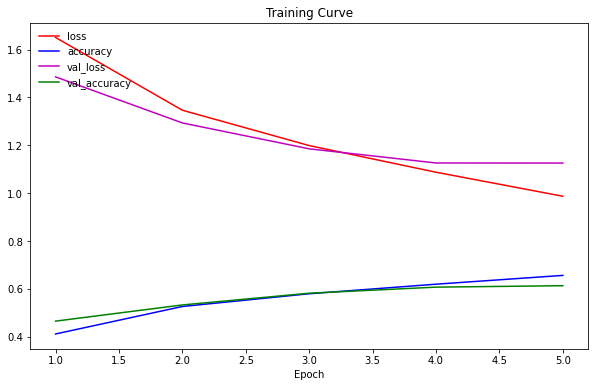

In [77]:
colors = {'loss':'r', 'accuracy':'b', 'val_loss':'m', 'val_accuracy':'g'}
plt.figure(figsize=(10,6))
plt.title("Training Curve") 
plt.xlabel("Epoch")

for measure in hist.keys():
    color = colors[measure]
    plt.plot(range(1,epochs+1), hist[measure], color + '-', label=measure)  # use last 2 values to draw line

plt.legend(loc='upper left', scatterpoints = 1, frameon=False)


# Data Augmentation

Increase the training set by adding more images: Rotate, shift, flip and scale the original images to generate additional examples that will help the Neural Network to generalize better.

In [80]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# recreate and recompile the model (otherwise we continue learning)
model = createMyModel()
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

# fits the model on batches with real-time data augmentation:
history = model.fit(datagen.flow(train_img, image_classes, batch_size=batch_size),
                    epochs=epochs) 

Epoch 1/5
1563/1563 [==============================] - 264s 168ms/step - loss: 2.0223 - accuracy: 0.2544
Epoch 2/5
1563/1563 [==============================] - 263s 168ms/step - loss: 1.8591 - accuracy: 0.3134
Epoch 3/5
1563/1563 [==============================] - 261s 167ms/step - loss: 1.7978 - accuracy: 0.3397
Epoch 4/5
1563/1563 [==============================] - 261s 167ms/step - loss: 1.7556 - accuracy: 0.3572
Epoch 5/5
1563/1563 [==============================] - 261s 167ms/step - loss: 1.7122 - accuracy: 0.3730


### Verifying Accuracy on Test Set (with Data Augmentation)

In [81]:
# verify accuracy on test set with augmentation
predictions = model.predict(test_img)
predicted_classes = np.argmax(predictions, axis=1)
accuracy_on_test_set = accuracy_score(test_image_labels_for_comparison, predicted_classes)
print('Accuracy on test set with augmentation: ' + str(accuracy_on_test_set))

313/313 [==============================] - 10s 32ms/step
Accuracy on test set with augmentation: 0.3495


### Plotting the Training Curve with Data Augmentation 

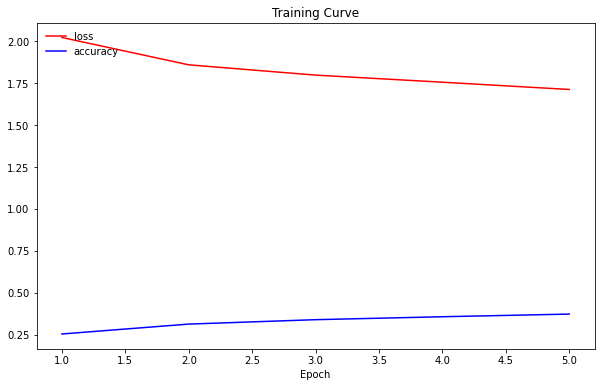

In [82]:
hist = history.history

plt.figure(figsize=(10,6))
plt.title("Training Curve") 
plt.xlabel("Epoch")

for measure in hist.keys():
    color = colors[measure]
    plt.plot(range(1,epochs+1), hist[measure], color + '-', label=measure)  # use last 2 values to draw line

plt.legend(loc='upper left', scatterpoints = 1, frameon=False)


This graph is not ideal, but we see both training (blue) and validation (green) Accuracy going up, the training loss and validation loss going continuously down.